Authors: Fernando Díaz González and Giorgio Ruffa
{fdiaz, ruffa}@kth.se

ID 2222 Data Mining. Assignment 1

# Finding Similar Items: Textually Similar Documents

In [11]:
import binascii
import copy
import glob
import itertools
import os
import os.path
import random
import time

from collections import defaultdict
from functools import reduce

## Data

`corpus_folder` should point to the folder containing the documents to process. We provided a small corpus of 10 emails (5 spam and 5 non-spam). This dataset is a subset of the [Enron Spam Dataset](http://nlp.cs.aueb.gr/software_and_datasets/Enron-Spam/index.html).

We use `corpus_test_folder` and `test_file_path` for unit testing. Please **do not** modify these.

In [12]:
corpus_folder = "./data/enrontest/"
corpus_test_folder = "./data/test"
test_file_path = "./data/test/1.txt"

## Shingling 

The following function computes the set of shigles (default size *k = 5*) of a given document. A function hashes each shingle to 32bit integer using a simple hash function. We decided to ignore parsing errors generated by special characters. 

Run the following code to compute the set of shingles of a small test file. We have parsed the output to show each raw shingle (substring) and the corresponding hashed value.

In [13]:
def file_to_shingles(file_path, shingle_size=5, do_hash=True):
    with open(file_path, 'r', errors='ignore') as infile:
        content = infile.read()
        shingles = set()
        for i in range(len(content) - shingle_size):
            shingle = content[i:i+shingle_size]
            shingles.add(
                hash_shingle(shingle) if do_hash else shingle
            )
        return sorted(list(shingles))

def hash_shingle(shingle):
    """Hashes a shingle to a 32bit integer.
    
    """
    return binascii.crc32(shingle.encode("utf-8")) & 0xffffffff

################
##### TEST #####
################
shingle_size = 5
print("Shingles in {} (<raw> --> <hashed>)".format(test_file_path))
shingles_raw = file_to_shingles(test_file_path, shingle_size=shingle_size, do_hash=False)
shingles_hashed = file_to_shingles(test_file_path, shingle_size=shingle_size, do_hash=True)
for shingle, shingle_hashed in zip(shingles_raw, shingles_hashed):
    print("{} --> {}".format(shingle, shingle_hashed))

if len(file_to_shingles(test_file_path)) != len(file_to_shingles(test_file_path, do_hash=False)):
    print("Hey, we have a problem!")

Shingles in ./data/test/1.txt (<raw> --> <hashed>)
 are  --> 149001033
 how  --> 505411656
 you? --> 1143360328
, how --> 1359422726
Hello --> 1383447317
are y --> 2003856980
e you --> 2143345793
ello, --> 2865029777
how a --> 2934440218
llo,  --> 3060865948
lo, h --> 3506996146
o, ho --> 3790226449
ow ar --> 4041755499
re yo --> 4071237501
w are --> 4157704578


This function computes the Jaccard similarity between two sets.

In [15]:
def jacard_similarity(set_1, set_2):
    return len(set_1.intersection(set_2)) / len(set_1.union(set_2))

################
##### TEST #####
################
set_1 = {"a", "b", "c"}
set_2 = {"b", "c", "d"} 
print("Jaccard similarity between {} and {} = {}".format(
    set_1, set_2, jacard_similarity(set_1, set_2)))

Jaccard similarity between {'b', 'a', 'c'} and {'d', 'b', 'c'} = 0.5


## Minhashing

The following class encapsulates functions to compute the signature of a given set of shingles. For example, by using 100 hash functions, we calculate a signature of length 100 of a given set of shingles.

When the class is initialized, a given number of hashing coefficients are computed. The function `get_signature(set_of_shingles)` returns the signature of the shingles set in form of a list where the _i_-th element represents the lowest hash calculated with the *i*-th hash function.

Regarding the hash functions used. They are of the form: $(a x + b) \bmod c$ where $c$ is the next prime bigger than the highest 32bit integer. Keep in mind that we do not check for overflow since integer in Python are of arbitrary precision. We later mask the result to a 32bit integer.

Run the following code to apply the Minhash algorithm to the set of shingles that we extracted in the previous section.

In [16]:
class HashStore:
    # next prime of 2^32 - 1 is 4294967311
    # http://compoasso.free.fr/primelistweb/page/prime/liste_online_en.php
    max_shingle_hash = 2**32 - 1
    next_prime = 4294967311
    
    def __init__(self, number_of_hash_functions=100, seed=None):
        if seed:
            random.seed(seed)
        self.n_hash_functions = number_of_hash_functions  # the length of the signature
        self.a_coefficients = self.generate_coefficient_list(number_of_hash_functions)
        self.b_coefficients = self.generate_coefficient_list(number_of_hash_functions)
    
    def generate_coefficient_list(self, number_of_coefficients):
        # integers in python have arbitrary precision (not applicable to numpy)
        # https://mortada.net/can-integer-operations-overflow-in-python.html
        coefficients = []
        
        def random_int():
            return random.randint(1, self.max_shingle_hash)
        
        for _ in range(number_of_coefficients):
            candidate = random_int()
            while candidate in coefficients:
                candidate = random_int()
            coefficients.append(candidate)
        
        return coefficients
    
    def hash_function(self, function_index, value):
        assert function_index < self.n_hash_functions, "Function index out of range"
        assert type(value) == int, "Cannot hash strings, yet..."
        a = self.a_coefficients[function_index]
        b = self.b_coefficients[function_index]
        return (a * value + b) % self.next_prime & 0xffffffff  # not really needed it
    
    def get_signature(self, set_of_shingles):
        signature = []  # needs to keep the order of insertion, the set will not grant it
        for i in range(self.n_hash_functions):
            signature.append(
                min(map(lambda x: self.hash_function(i,x) , set_of_shingles))
            )
        return signature
    
            
################
##### TEST #####
################
n_hash_functions = 8
hash_store = HashStore(n_hash_functions, seed=42)
shingles_set = file_to_shingles(test_file_path)
set_signature = hash_store.get_signature(shingles_set)
print("Signature of document {} (using {} hash functions)".format(test_file_path, n_hash_functions))
print(hash_store.get_signature(shingles_set))

Signature of document ./data/test/1.txt (using 8 hash functions)
[463515652, 443568431, 268886043, 244649804, 293593135, 84817191, 180619760, 452621026]


## Compare signatures

* The function `compare_signatures` returns the fraction of components in which two signatures agree.

* The function `find_similar_sets` receives a collection of sets (e.g., minhash signatures), a similarity threshold and a similarity function (e.g., `compare_signatures` or `jaccard_similarity`) and returns pairs of sets that have a similarity higher than the threshold.

In [17]:
def compare_signatures(sign1, sign2):
    assert len(sign1) == len(sign2)
    # this is one liner in numpy, but we decided to use only plain python
    # also with numpy we must pay attention to not overflow when calculating
    # the hashes
    return sum([x == y for x,y in zip(sign1, sign2)]) / len(sign1)

def find_similar_sets(collection_sets, threshold, similarity_fn):
    similar_docs = set()
    for (i, sign1), (j, sign2) in itertools.combinations(enumerate(collection_sets), 2):
        similarity = similarity_fn(sign1, sign2)
        if similarity >= threshold:
            similar_docs.add((i, j, similarity))
    return similar_docs

################
##### TEST #####
################
n_hash_functions = 8
hash_store = HashStore(n_hash_functions, seed=42)
file_list = glob.glob(os.path.join(corpus_test_folder, "*"))
shingle_sets = list(map(file_to_shingles, file_list))
signature_matrix = list(map(hash_store.get_signature , shingle_sets))
print("Using {} hash functions!".format(n_hash_functions))
print("Processed files:")
print(file_list)
print("Signature matrix ({} x {}):".format(len(signature_matrix), len(signature_matrix[0])))
print('\n'.join([' '.join(['{:10}'.format(item) for item in row]) 
      for row in signature_matrix]))
for (i, sign1), (j, sign2) in itertools.combinations(enumerate(signature_matrix), 2):
    print("Similarity between {} and {} = {}".format(file_list[i], file_list[j], 
                                                     compare_signatures(sign1,sign2)))

Using 8 hash functions!
Processed files:
['./data/test/1.txt', './data/test/3.txt', './data/test/2.txt']
Signature matrix (3 x 8):
 463515652  443568431  268886043  244649804  293593135   84817191  180619760  452621026
  82669165  382588255  225752293  244649804  100267120  301994720  180619760   75250735
  30580286  256165265  281393600  103047546  248154674   20494360   48809749  264570825
Similarity between ./data/test/1.txt and ./data/test/3.txt = 0.25
Similarity between ./data/test/1.txt and ./data/test/2.txt = 0.0
Similarity between ./data/test/3.txt and ./data/test/2.txt = 0.0


## Locality Sensitive Hashing

This class implements LSH for a signature matrix, given the total number of bands and a similarity threshold. The flow is as follows:

* `get_similar` compares then signatures of candidate pairs returned by `get_candidates` and filters them depending of the similarity threshold.

* `get_candidates`, for each band calculates the band's candidates using `get_band_candidates` and return an union of them without repetitions.

* `get_band_candidates`, for each document hashes the corresponding part of the signature and returns pairs of documents in the same bucket.

For ease of implementation, we are using a Python dictionary as a hash table to handle the buckets.

In [18]:
class LSH:
    def __init__(self, signature_matrix, bands, threshold = 0.5):
        # using only bands because the bands * rows = len(signature)
        self.signature_matrix = signature_matrix
        self.bands = bands
        # the last band, if not completed, is hashed anyway
        self.signature_length = len(self.signature_matrix[0])
        
        assert self.signature_length >= self.bands
        self.rows = self.signature_length // self.bands
        
        self.threshold = threshold
    
    def hash_band_item(self, band):
        return reduce(lambda x,y : "{}{}".format(x,y), band)
        
    def get_band_item(self, band_index, doc_index):
        start_index = band_index * self.rows
        end_index = min((band_index + 1) * self.rows, self.signature_length)
        assert start_index < end_index
        return self.signature_matrix[doc_index][start_index : end_index]
    
    def get_band_candidates(self, band_index):
        hash_table = defaultdict(list)
        for doc_index in range(len(self.signature_matrix)) :
            band_item = self.get_band_item(band_index, doc_index)
            hash_table[self.hash_band_item(band_item)].append(doc_index)
        
        candidates = []
        for values in hash_table.values():
            if len(values) > 1:
                 # get the list of candidate PAIRS
                candidates += list(itertools.combinations(sorted(values), 2))
        return set(candidates)  # unique pairs
    
    def get_candidates(self):
        candidates = set()
        for i in range(self.bands):
            candidates = candidates.union(self.get_band_candidates(i))
        return candidates
    
    def get_similar(self):
        similar_docs = set()
        candidates = self.get_candidates()
        for doc_index_1, doc_index_2 in candidates:
            sign1, sign2 = signature_matrix[doc_index_1], signature_matrix[doc_index_2]
            similarity = compare_signatures(sign1, sign2)
            if similarity >= self.threshold:
                similar_docs.add((doc_index_1,doc_index_2,similarity))
        return similar_docs

## Comparison between Minhashing and Minhashing + LSH

In the following example we apply the Minhash (+LSH) algorithm to a corpus of 10 documents. We use 100 hash functions and an arbitrary threshold of 0.4. We use 20 bands for the LSH algorithm.

It is possible to see how, for a small dataset, there is no gain in performance using LSH. In fact, it is more expensive to compute the hashes for each band than to compute the similarity between all the documents. Hence, the reduction of the number of comparisons does not bring any performance gain.

The results show that 2 distinct pairs of smap emails have very high similarit, while legit emails don not.  

In [19]:
################
## REAL TEST ###
################
def print_ranking(results, time, top=10):
    print("***** RANKING ({:d} pairs retrieved in {:d}ms) *****".format(len(results), time))
    for rank, (doc1_idx, doc2_idx, similarity) in enumerate(results):
        doc1 = file_list[doc1_idx]
        doc2 = file_list[doc2_idx]
        print("Similarity: {:4}".format(similarity))
        print("{} and {}".format(doc1, doc2))
        print("*****")
        if rank == top:
            break
        
def millis():
    return int(round(time.time() * 1000))

#### CONFIG ####
threshold = 0.4
n_hash_functions = 100
bands = 20  # lower or equal to the number of hash functions!
################
rows = n_hash_functions // bands

file_list = glob.glob(os.path.join(corpus_folder, "*"))
print("Configuration:")
print(" - Number of files:", len(file_list))
print(" - Number of hash functions:", n_hash_functions)
print(" - Number of bands:", bands)
print(" - Number of rows per band (inferred):", rows)
print(" - LSH similarity threshold 't':", threshold)

tick = millis()
print("Converting to shingles...")
shingle_sets = list(map(file_to_shingles, file_list))
hash_store = HashStore(n_hash_functions, seed=42)
print("Generating signatures...")
signature_matrix = list(map(hash_store.get_signature , shingle_sets))
tock = millis()
time_minhashing = (tock - tick)
print("\nMinhashing time: {}ms".format(time_minhashing))
print("Signature matrix shape: {} x {}".format(len(signature_matrix), 
                                               len(signature_matrix[0])))

print("\n***** LSH *****")
tick = millis()
lsh = LSH(signature_matrix, bands, threshold)
similar_pairs = lsh.get_similar()
tock = millis()
time_lsh = (tock - tick)

similar_pairs = sorted(similar_pairs, key=lambda x: x[2], reverse=True)  # rank
print_ranking(similar_pairs, time_lsh)

# Compare it to the time to compute all the similarities
print("\n***** ALL *****")
tick = millis()
similar_pairs_all = find_similar_sets(signature_matrix, threshold, similarity_fn=compare_signatures)
tock = millis()
time_all = (tock - tick)
similar_pairs_all = sorted(similar_pairs_all, key=lambda x: x[2], reverse=True)  # rank
print_ranking(similar_pairs_all, time_all)

Configuration:
 - Number of files: 10
 - Number of hash functions: 100
 - Number of bands: 20
 - Number of rows per band (inferred): 5
 - LSH similarity threshold 't': 0.4
Converting to shingles...
Generating signatures...

Minhashing time: 745ms
Signature matrix shape: 10 x 100

***** LSH *****
***** RANKING (2 pairs retrieved in 1ms) *****
Similarity: 0.91
./data/enrontest/spam_email2.txt and ./data/enrontest/spam_email1.txt
*****
Similarity:  0.8
./data/enrontest/spam_email4.txt and ./data/enrontest/spam_email5.txt
*****

***** ALL *****
***** RANKING (2 pairs retrieved in 0ms) *****
Similarity: 0.91
./data/enrontest/spam_email2.txt and ./data/enrontest/spam_email1.txt
*****
Similarity:  0.8
./data/enrontest/spam_email4.txt and ./data/enrontest/spam_email5.txt
*****


## Scalling up (don't run!)

In order to evaluate the performance gain of LSH we are going to test it on a bigger corpus of only spam emails (**1500** in total).

As we can see, the speedup is $\frac{13663}{148} = 92$ times faster, although in this case we have false negatives. For this reason we are going to investigate the behavior of precision and recall in function of the number of bands.

In [20]:
corpus_folder_big = "./data/spam/"

#### CONFIG ####
threshold = 0.4
n_hash_functions = 100
bands = 20  # lower or equal to the number of hash functions!
################
rows = n_hash_functions // bands

file_list = glob.glob(os.path.join(corpus_folder_big, "*"))
print("Configuration:")
print(" - Number of files:", len(file_list))
print(" - Number of hash functions:", n_hash_functions)
print(" - Number of bands:", bands)
print(" - Number of rows per band (inferred):", rows)
print(" - LSH similarity threshold 't':", threshold)

tick = millis()
print("Converting to shingles...")
shingle_sets = list(map(file_to_shingles, file_list))
hash_store = HashStore(n_hash_functions, seed=42)
print("Generating signatures...")
signature_matrix = list(map(hash_store.get_signature , shingle_sets))
tock = millis()
time_minhashing = (tock - tick)
print("\nMinhashing time: {}ms".format(time_minhashing))
print("Signature matrix shape: {} x {}".format(len(signature_matrix), 
                                               len(signature_matrix[0])))

print("\n***** LSH *****")
tick = millis()
lsh = LSH(signature_matrix, bands, threshold)
similar_pairs = lsh.get_similar()
tock = millis()
time_lsh = (tock - tick)

similar_pairs = sorted(similar_pairs, key=lambda x: x[2], reverse=True)  # rank
print_ranking(similar_pairs, time_lsh)

# Compare it to the time to compute all the similarities
print("\n***** ALL *****")
tick = millis()
similar_pairs_all = find_similar_sets(signature_matrix, threshold, similarity_fn=compare_signatures)
tock = millis()
time_all = (tock - tick)
similar_pairs_all = sorted(similar_pairs_all, key=lambda x: x[2], reverse=True)  # rank
print_ranking(similar_pairs_all, time_all)

Configuration:
 - Number of files: 1500
 - Number of hash functions: 100
 - Number of bands: 20
 - Number of rows per band (inferred): 5
 - LSH similarity threshold 't': 0.4
Converting to shingles...
Generating signatures...

Minhashing time: 144470ms
Signature matrix shape: 1500 x 100

***** LSH *****
***** RANKING (883 pairs retrieved in 169ms) *****
Similarity:  1.0
./data/spam/3257.2004-12-21.GP.spam.txt and ./data/spam/1679.2004-07-22.GP.spam.txt
*****
Similarity:  1.0
./data/spam/1679.2004-07-22.GP.spam.txt and ./data/spam/3266.2004-12-23.GP.spam.txt
*****
Similarity:  1.0
./data/spam/2123.2004-09-12.GP.spam.txt and ./data/spam/2158.2004-09-13.GP.spam.txt
*****
Similarity:  1.0
./data/spam/2175.2004-09-15.GP.spam.txt and ./data/spam/3579.2005-01-25.GP.spam.txt
*****
Similarity:  1.0
./data/spam/2629.2004-10-26.GP.spam.txt and ./data/spam/2681.2004-10-31.GP.spam.txt
*****
Similarity:  1.0
./data/spam/3661.2005-02-02.GP.spam.txt and ./data/spam/3748.2005-02-07.GP.spam.txt
*****
Sim

## Confusion Matrix

For the following section we are going to consider that the ground truth are the similar sets returned by comparing all the signatures. Then, using the result from the LSH algorithm, we will analyse precision and recall.

In [10]:
# https://en.wikipedia.org/wiki/Precision_and_recall
# We are going to:
# 1. Get similar pairs of documents using Jaccard similarity (via shingles)
#    This will be our "ground truth"
# 2. Get similar pairs of documents using LSH (via signature matrix)
#    This will be our "selected positives examples (some of the migh be FP)"
# 3. Compute precision and recall.

# 1.Get similar pairs of documents using signatures
relevant_elements = copy.deepcopy(similar_pairs_all)
# Remove similarity. Just keep the pair of indexes
relevant_elements = {(x[0], x[1]) for x in relevant_elements}
# Find how many document pairs exist ((n * (n - 1)) / 2)
n = len(file_list)
number_possible_pairs = (n * (n - 1)) // 2
print("Relevant (similar) sets using signature similarity (threshold = {}):".format(threshold))
print(len(relevant_elements))
print("Total combinations: {}. Relevant: {}. Nonrelevant: {}".format(
    number_possible_pairs, len(relevant_elements), number_possible_pairs - len(relevant_elements)))

# 2. Get similar pairs of documents using LSH (via signature matrix)
selected_positives = copy.deepcopy(similar_pairs)
# Remove similarity. Just keep the pair of indexes
selected_positives = {(x[0], x[1]) for x in selected_positives}
print("Relevant (similar) sets using LSH (threshold = {}):".format(threshold))
print(len(selected_positives))

# 3. Compute precision and recall.
def confusion_matrix(relevant_elements, selected_positives, number_possible_pairs):
    tp = 0
    fp = 0
    for pair in selected_positives:
        if pair in relevant_elements:
            tp += 1
        else:
            fp += 1
    # False negatives are the remaining pairs that we haven't checked
    fn = len(relevant_elements - selected_positives)
    # True negatives are the remaining sets
    tn = number_possible_pairs - (tp + fp + fn)
    if tp == 0:
        prec = rec = 0
    else:
        prec = tp / (tp + fp)
        rec = tp / (tp + fn)
    return {"tp": tp, "fp": fp, "tn": tn, "fn": fn, 
            "prec": prec, "rec": rec}

def print_confusion_matrix(cm):
    print("\n***** Confusion Matrix *****")
    print("True positives:  {:d}".format(cm["tp"]))
    print("True negatives:  {:d}".format(cm["tn"]))
    print("False positives: {:d}".format(cm["fp"]))
    print("False negatives: {:d}".format(cm["fn"]))
    print("**********")
    print("Precision: {:.3f}".format(cm["prec"]))
    print("Recall:    {:.3f}".format(cm["rec"]))
    print("****************************")

cm = confusion_matrix(relevant_elements, selected_positives, number_possible_pairs)
print_confusion_matrix(cm)

Relevant (similar) sets using signature similarity (threshold = 0.4):
1339
Total combinations: 1124250. Relevant: 1339. Nonrelevant: 1122911
Relevant (similar) sets using LSH (threshold = 0.4):
883

***** Confusion Matrix *****
True positives:  883
True negatives:  1122911
False positives: 0
False negatives: 456
**********
Precision: 1.000
Recall:    0.659
****************************


## Precision and recall curves

Finally, we are going to see how the precision and recall vary when changing the number of bands.

In [12]:
# Super mega hyper fun part (but run the code above first!)
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

results = defaultdict(list)

#### CONFIG ####
threshold = 0.4
band_values_to_try = 20
################
band_values = np.linspace(1, n_hash_functions, band_values_to_try, dtype=int)

for bands in tqdm_notebook(band_values):
    lsh = LSH(signature_matrix, bands, threshold)
    selected_positives = lsh.get_similar()
    # Remove similarity. Just keep the pair of indexes
    selected_positives = {(x[0], x[1]) for x in selected_positives}
    cm = confusion_matrix(relevant_elements, selected_positives, number_possible_pairs)
    for key, value in cm.items():
        results[key].append(value)
    results["bands"].append(bands)
    results["threshold"].append(threshold)
    
df_results = pd.DataFrame(results)

### True positives vs False Negatives

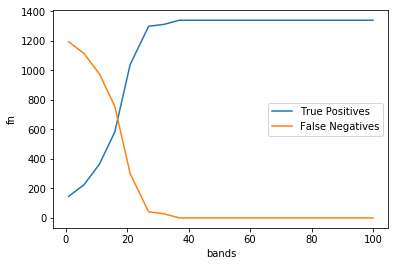

In [13]:
ax = sns.lineplot(x="bands", y="tp", markers=True, label="True Positives", data=df_results)
sns.lineplot(x="bands", y="fn", markers=True, label="False Negatives", data=df_results, ax=ax)

### Precision vs Recall

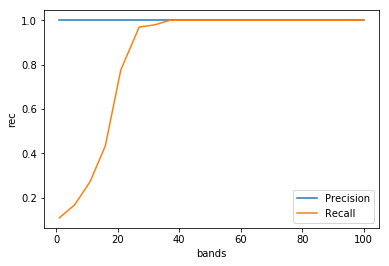

In [14]:
ax = sns.lineplot(x="bands", y="prec", markers=True, label="Precision", data=df_results)
ax = sns.lineplot(x="bands", y="rec", markers=True, label="Recall", data=df_results, ax=ax)